# 1.Frame the problem

this is a classification problem and we got original data which contains 5 features and 3 labels, each pixel can regarded as a sample

# 2.Input the data

In [1]:
import pandas as pd
from scipy.io import loadmat

#data=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\dataset.mat")
dataset=loadmat("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\dataset.mat",mat_dtype=True)

In [2]:
data=dataset["dataset"]
type(data)

numpy.ndarray

then we try to plot one image to see what it looks like

In [3]:
data1=data.tolist()
for i in range(len(data1)):
    print(data[i][0][0][0][0][:,:,3,1].shape)

(34, 41)
(80, 82)
(82, 74)
(89, 102)
(66, 78)
(69, 83)
(50, 57)
(55, 69)
(64, 65)
(99, 83)
(107, 99)
(320, 320)
(320, 320)
(320, 320)


In [4]:
data2=data[1][0][0][0][0][:,:,8,0] #[:,:,slices,features]

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def plot_image(data,stuck,slices,features):
    target_data=data[stuck][0][0][0][0][:,:,slices,features]
    target_image=target_data.reshape(target_data.shape[0],target_data.shape[1])
    plt.imshow(target_image,cmap = matplotlib.cm.binary)
    plt.axis("off") #close the axis number
    plt.show()


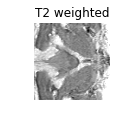

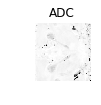

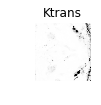

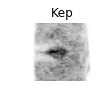

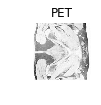

In [6]:
stuck,slices,features=13,10,0
plt.figure(figsize=(8,4))

plt.subplot(151)
plt.title("T2 weighted")
plot_image(data,stuck,slices,features)

plt.subplot(152)
plt.title("ADC")
plot_image(data,stuck,slices,features+1)

plt.subplot(153)
plt.title("Ktrans")
plot_image(data,stuck,slices,features+2)

plt.subplot(154)
plt.title("Kep")
plot_image(data,stuck,slices,features+3)

plt.subplot(155)
plt.title("PET")
plot_image(data,stuck,slices,features+4)

then we try to find out the labels distribution

In [7]:
labelA=data[3][0][0][0][1]
labelA.shape

(89, 102, 85)

In [8]:
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap',['black','red','blue'],256)
def plot_all(data,stuck,index,slices,features):
    target_data=data[stuck][0][0][0][0][:,:,slices,features]
    target_image1=target_data.reshape(target_data.shape[0],target_data.shape[1])
    target_label=data[stuck][0][0][0][index][:,:,slices]
    target_image2=target_label.reshape(target_label.shape[0],target_label.shape[1])
    plt.imshow(target_image1,cmap = matplotlib.cm.binary,alpha=0.8)
    plt.imshow(target_image2,cmap = cmap1,interpolation="bilinear",alpha=0.2)
    plt.axis("off") #close the axis number
    plt.show()



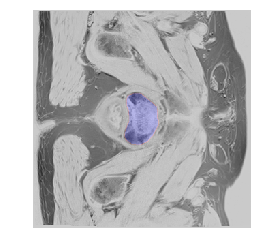

In [9]:
stuck,slices,index,features=11,16,3,4
#plot_image(data,stuck,slices,0)
#plot_label(data,stuck,2,slices)
plot_all(data,stuck,index,slices,features)

# 3. Exploring the features

## 3.1 Extract prostate region

we can find that 1-11 strucks are expected by experts and 12-14 are histological analysis because it is more reliable than the experts,and later 1-11 strucks will be out training set and 12-14 will be out validation set

In [10]:
import numpy as np
experts_num,histo_num=11,3
label_final=[]
for i in range(experts_num):
    labelA=data[i][0][0][0][1]
    labelB=data[i][0][0][0][2]
    for index,(item_A,item_B) in enumerate(zip(labelA.flat,labelB.flat)):
                if item_A == item_B:
                    pass
                else:
                    labelA.flat[index]=0
    label_final.append(labelA)


then append the histological struck

In [11]:
for j in range(histo_num):
    labelC=data[j+11][0][0][0][3]
    label_final.append(labelC)

label=np.array(label_final)
label.shape

(14,)

then our task divided into two parts:
- isolate the feature vector of prostate tissure from the whole set
- try to transfer first feature TR wighted MR images

then let us create train data set and validation set respectively

In [12]:
train_data=data[:experts_num]
train_label=label[:experts_num]
val_data=data[:-experts_num]
val_label=label[:-experts_num]
val_label.shape

(3,)

In [13]:
train_isolated_feature=[]
train_isolated_label=[]
val_isolated_feature=[]
val_isolated_label=[]
def isolate_feature(data,label,isolated_feature,isolated_label):
    for i in range(len(data)):
        image=data[i][0][0][0][0]
        target_image=image.reshape(image.shape[0]*image.shape[1]*image.shape[2],image.shape[3])
        target_label=label[i].reshape(-1,1)
        for index,item in enumerate(target_label):
            if item == 0 :
                pass
            else:
                isolated_label.append(item)
                isolated_feature.append(target_image[index])
    return isolated_feature,isolated_label
        

isolate_feature(train_data,train_label,train_isolated_feature,train_isolated_label)
isolate_feature(val_data,val_label,val_isolated_feature,val_isolated_label)
    

([array([  2.18176367e+03,   8.94856453e-01,   2.15130001e-01,
           6.40297234e-01,   6.28385559e+02]),
  array([  2.15793042e+03,   9.39292848e-01,   2.22031489e-01,
           6.49604976e-01,   6.35664246e+02]),
  array([  2.09600537e+03,   7.58210182e-01,   1.85768008e-01,
           7.76954591e-01,   6.51411133e+02]),
  array([  2.05444409e+03,   6.12265468e-01,   1.41570568e-01,
           7.66034961e-01,   6.40429260e+02]),
  array([  2.46423242e+03,   1.00119185e+00,   1.73720211e-01,
           6.82743251e-01,   6.01125061e+02]),
  array([  2.42839258e+03,   1.07515264e+00,   1.85059294e-01,
           6.56937480e-01,   4.59472931e+02]),
  array([  2.40001636e+03,   1.12163734e+00,   1.94557875e-01,
           6.09147310e-01,   5.77129395e+02]),
  array([  2.36739111e+03,   1.11460996e+00,   2.09983736e-01,
           5.87056994e-01,   6.81447632e+02]),
  array([  2.26722437e+03,   1.08273470e+00,   1.88047618e-01,
           5.88620126e-01,   4.95779510e+02]),
  array([ 

In [14]:
train_isolated_feature=np.array(train_isolated_feature)
train_isolated_label=np.array(train_isolated_label)
train_isolated_feature.shape

(355455, 5)

In [15]:
sum_d=0
for i in range(11):
    temp_data=data[i][0][0][0][0]
    temp_d=temp_data.reshape(temp_data.shape[0]*temp_data.shape[1]*temp_data.shape[2],temp_data.shape[3])
    sum_d +=temp_d.shape[0]
    
sum_d

4696937

so we see we isolated the 355455 prostate features from the 4696937 the whole train set

then try to construct the whole pipeline of the features enginerring
- Transform the first feature TR wighted
- normalize all the features
- Outlier detection and removal

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0, 1), copy=True)

class Feature_scaling(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        scaler.fit(X[:,0])
        return self
    def transform(self,X,y=None):
        X[:,0]=scaler.transform(X[:,0])
        return X
     

In [17]:
from sklearn.pipeline import Pipeline

feature_eng=Pipeline([("feature_scale",Feature_scaling())])

In [18]:
test=10*np.random.rand(10,2)
test

array([[ 8.073199  ,  9.24599767],
       [ 6.74710298,  6.68758518],
       [ 1.90804551,  6.53968894],
       [ 0.94617031,  4.33564826],
       [ 7.51078174,  2.17189892],
       [ 4.33700212,  8.20034751],
       [ 4.17678507,  9.82658618],
       [ 9.3435296 ,  1.41011205],
       [ 3.53379231,  1.72241044],
       [ 7.47063158,  0.88642637]])

In [19]:
feature_eng.fit_transform(test)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([[ 0.84872261,  9.24599767],
       [ 0.69080439,  6.68758518],
       [ 0.11454496,  6.53968894],
       [ 0.        ,  4.33564826],
       [ 0.78174712,  2.17189892],
       [ 0.4037974 ,  8.20034751],
       [ 0.38471794,  9.82658618],
       [ 1.        ,  1.41011205],
       [ 0.30814711,  1.72241044],
       [ 0.77696583,  0.88642637]])